# Data visualization for a single file

Generates 5 plots:
1. Time series of 4 sensor signals
2. Time series of accerometer signal
3. Power spectral density for sensor signals
4. Continuous wavelet transform for sensor signals
5. PCA and ICA decomposition

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal as signal
import datetime

%matplotlib notebook

## Functions to be used later

In [13]:
def dc_offset_correction(signal):
    dc_offset = np.repeat(np.mean(signal),len(signal))
    return signal-dc_offset

## Load file

In [14]:
# list all files in directory
files = !ls *xq*.csv

In [15]:
file_num = 0
data = pd.read_csv(files[file_num], usecols = ['#time', 'seq', 'c0','c1','c2','c3','imu_mag', 'user_id', 'mac_address', 'start_time', 'stop_time','note'])

In [16]:
# change unix time stamp to date time format
data['#time'] = [datetime.datetime.fromtimestamp(s/1000.0) for s in data['#time']]

In [17]:
# calculate sampling rate

seq_int = data['seq'].diff() # change in seq number between consecutive samples
seq_breaks = np.where(seq_int < 1) # indices where change was neg
seq_breaks = seq_breaks[0]-1

if len(seq_breaks) == 0:
    fs = len(data['#time']) / datetime.timedelta.total_seconds(data['#time'].iloc[-1] - data['#time'].iloc[0])
else:
    fs = (seq_breaks[0]) / datetime.timedelta.total_seconds(data['#time'].iloc[seq_breaks[0]] - data['#time'].iloc[1])

fs=int(fs)

## Correct DC offset

In [18]:
# correct for DC offset

data['c0'] = dc_offset_correction(data['c0'])
data['c1'] = dc_offset_correction(data['c1'])
data['c2'] = dc_offset_correction(data['c2'])
data['c3'] = dc_offset_correction(data['c3'])

## Plot raw sensor signals

<IPython.core.display.Javascript object>


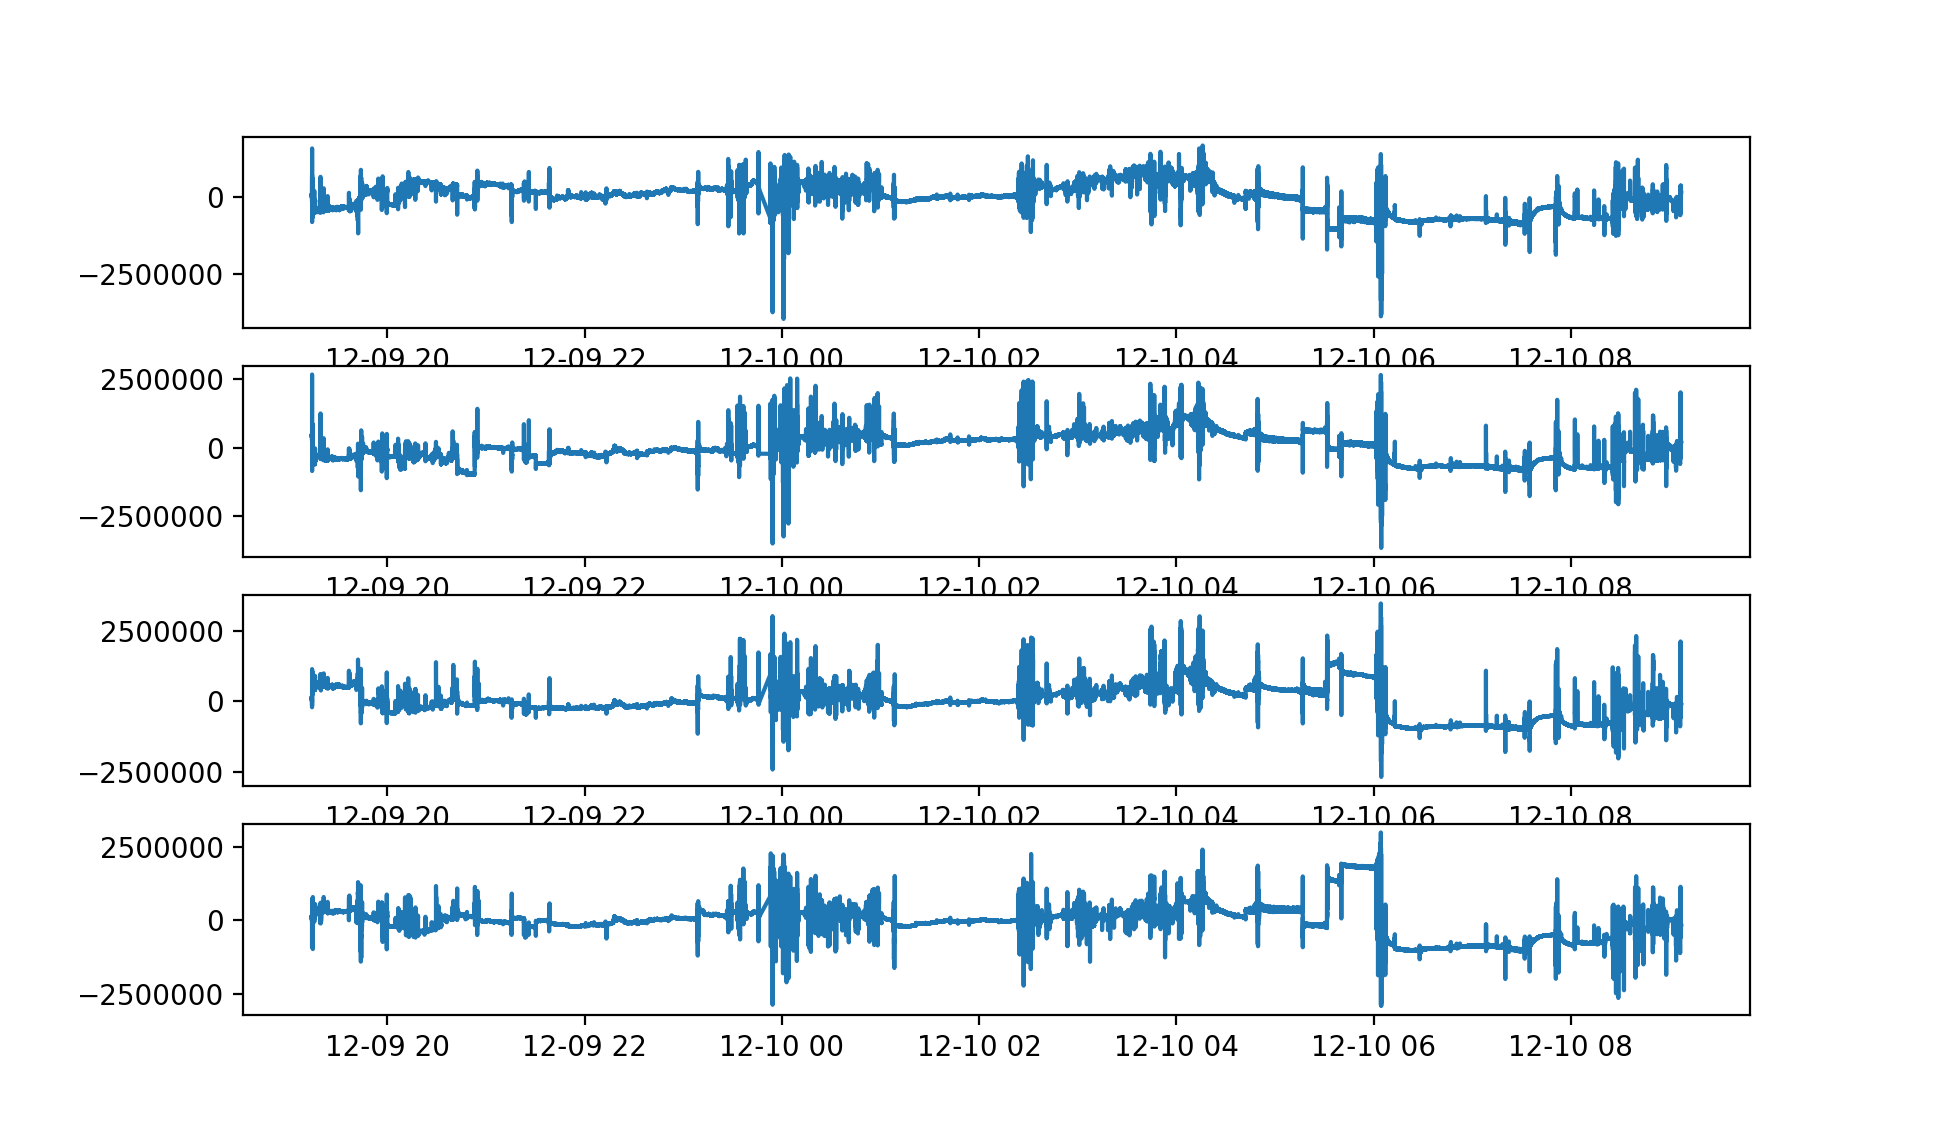

In [21]:
from pandas.plotting import register_matplotlib_converters

fig_raw_sensor, axs = plt.subplots(4, 1)

axs[0].plot(data['#time'], data['c0'])
axs[1].plot(data['#time'], data['c1'])
axs[2].plot(data['#time'], data['c2'])
axs[3].plot(data['#time'], data['c3'])

## Plot accelerometer over sensor signal
If motion is introducing common signals into both, you should see highly correlated activity

<IPython.core.display.Javascript object>


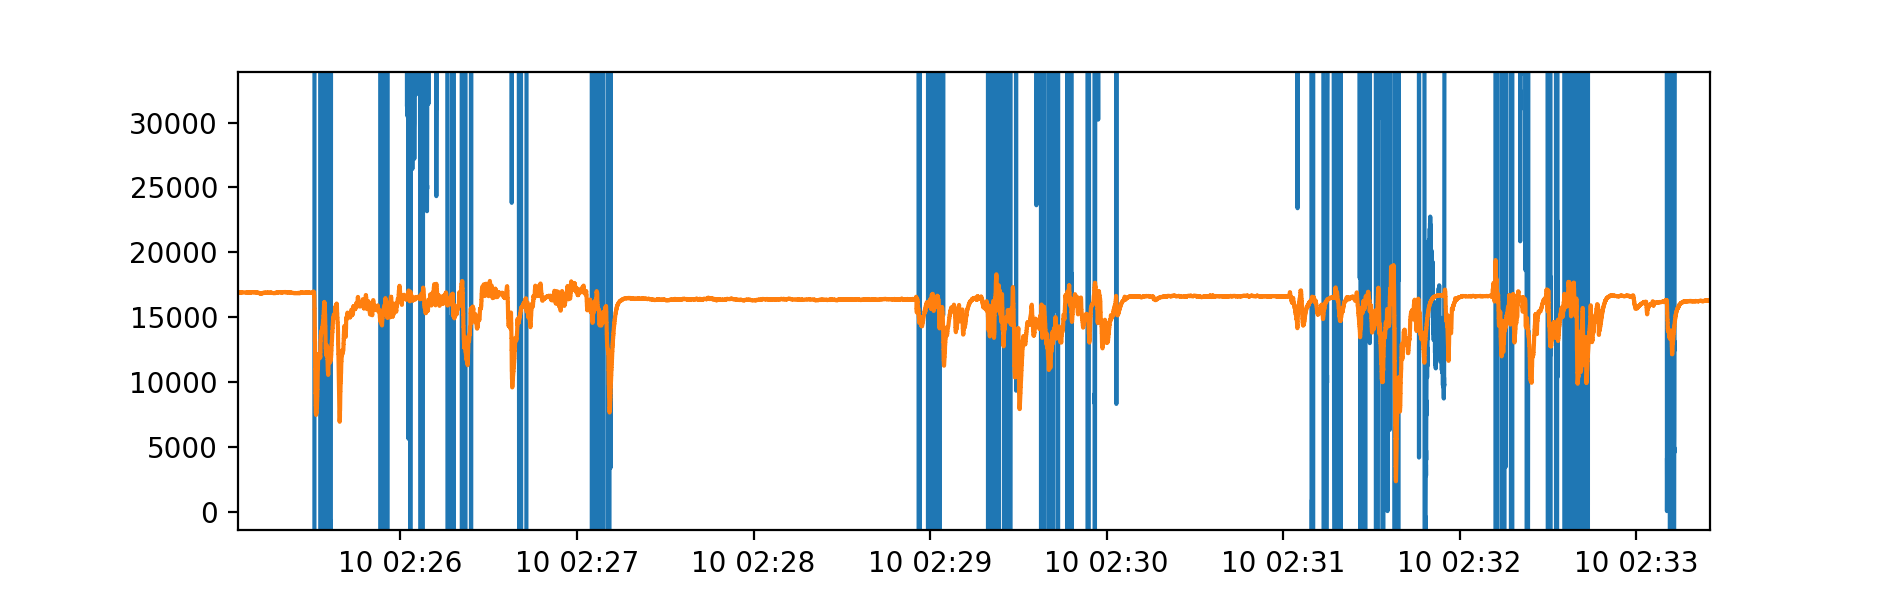

In [22]:
fig_accel, ax = plt.subplots()
ax.plot(data['#time'], data['c0'])
ax.plot(data['#time'], data['imu_mag'])

## Welch periodogram
Assess the power spectra of the signals.

In [24]:
# welch PSD
psd = pd.DataFrame(columns=['c0','c1','c2','c3'])

window = 200 
overlap = int(window/4)

f, psd.c0 = signal.welch(data['c0'], fs, nperseg=window, noverlap=overlap)
f, psd.c1 = signal.welch(data['c1'], fs, nperseg=window, noverlap=overlap)
f, psd.c2 = signal.welch(data['c2'], fs, nperseg=window, noverlap=overlap)
f, psd.c3 = signal.welch(data['c3'], fs, nperseg=window, noverlap=overlap)

<IPython.core.display.Javascript object>


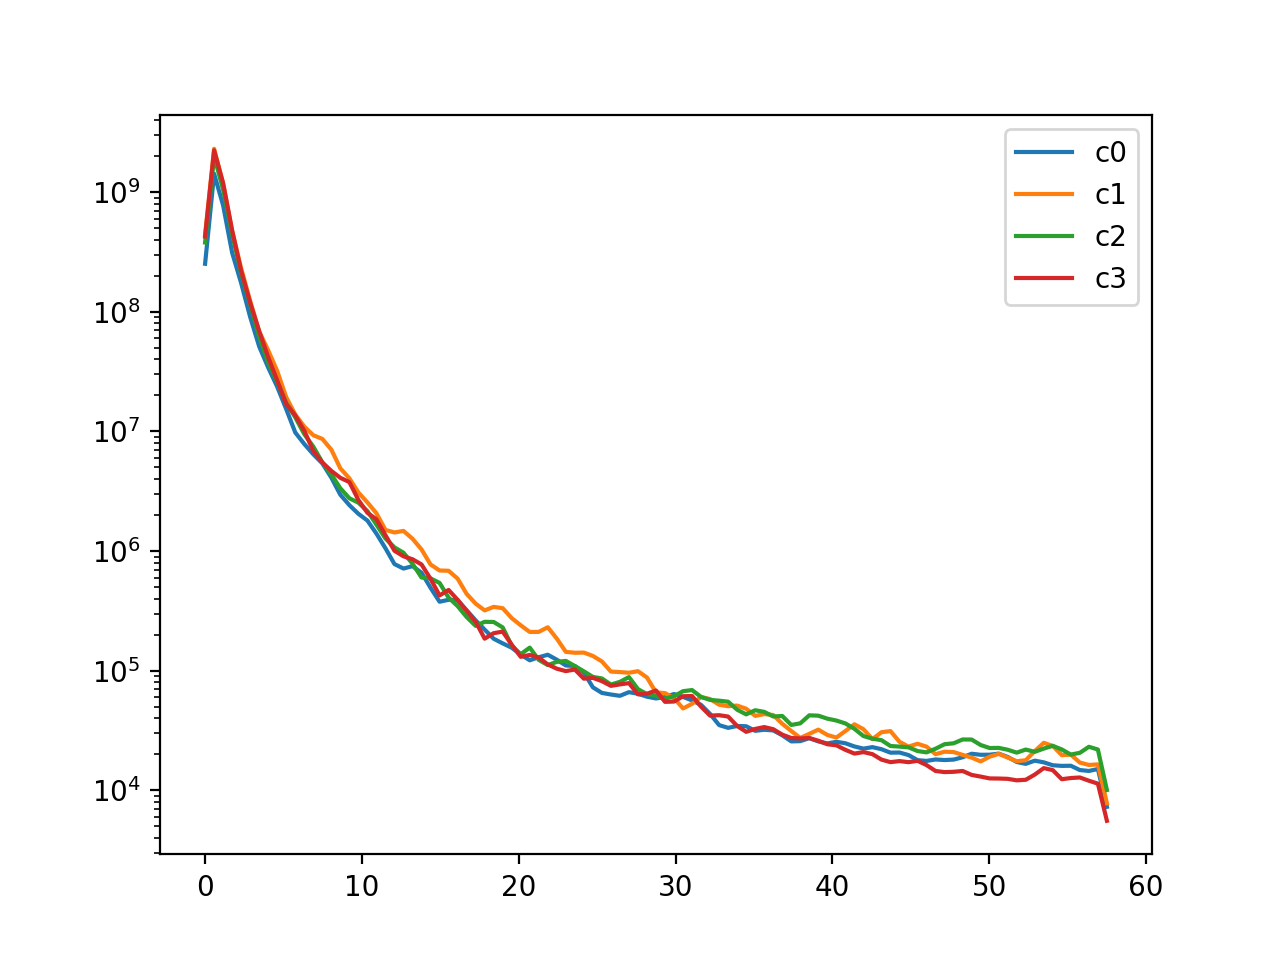

In [25]:
# plot power spectra

fig,ax = plt.subplots()
ax.semilogy(f, psd.c0)
ax.semilogy(f, psd.c1)
ax.semilogy(f, psd.c2)
ax.semilogy(f, psd.c3)
ax.legend(['c0','c1','c2','c3'])

## Continuous wavelet transform
Assess any temporality of spectral modulations.

In [29]:
# continuous wavelet transform

cwt0 = signal.cwt(data['c0'], signal.ricker, widths=np.logspace(1,30))
cwt1 = signal.cwt(data['c1'], signal.ricker, widths=np.logspace(1,30))
cwt2 = signal.cwt(data['c2'], signal.ricker, widths=np.logspace(1,30))
cwt3 = signal.cwt(data['c3'], signal.ricker, widths=np.logspace(1,30))

<IPython.core.display.Javascript object>


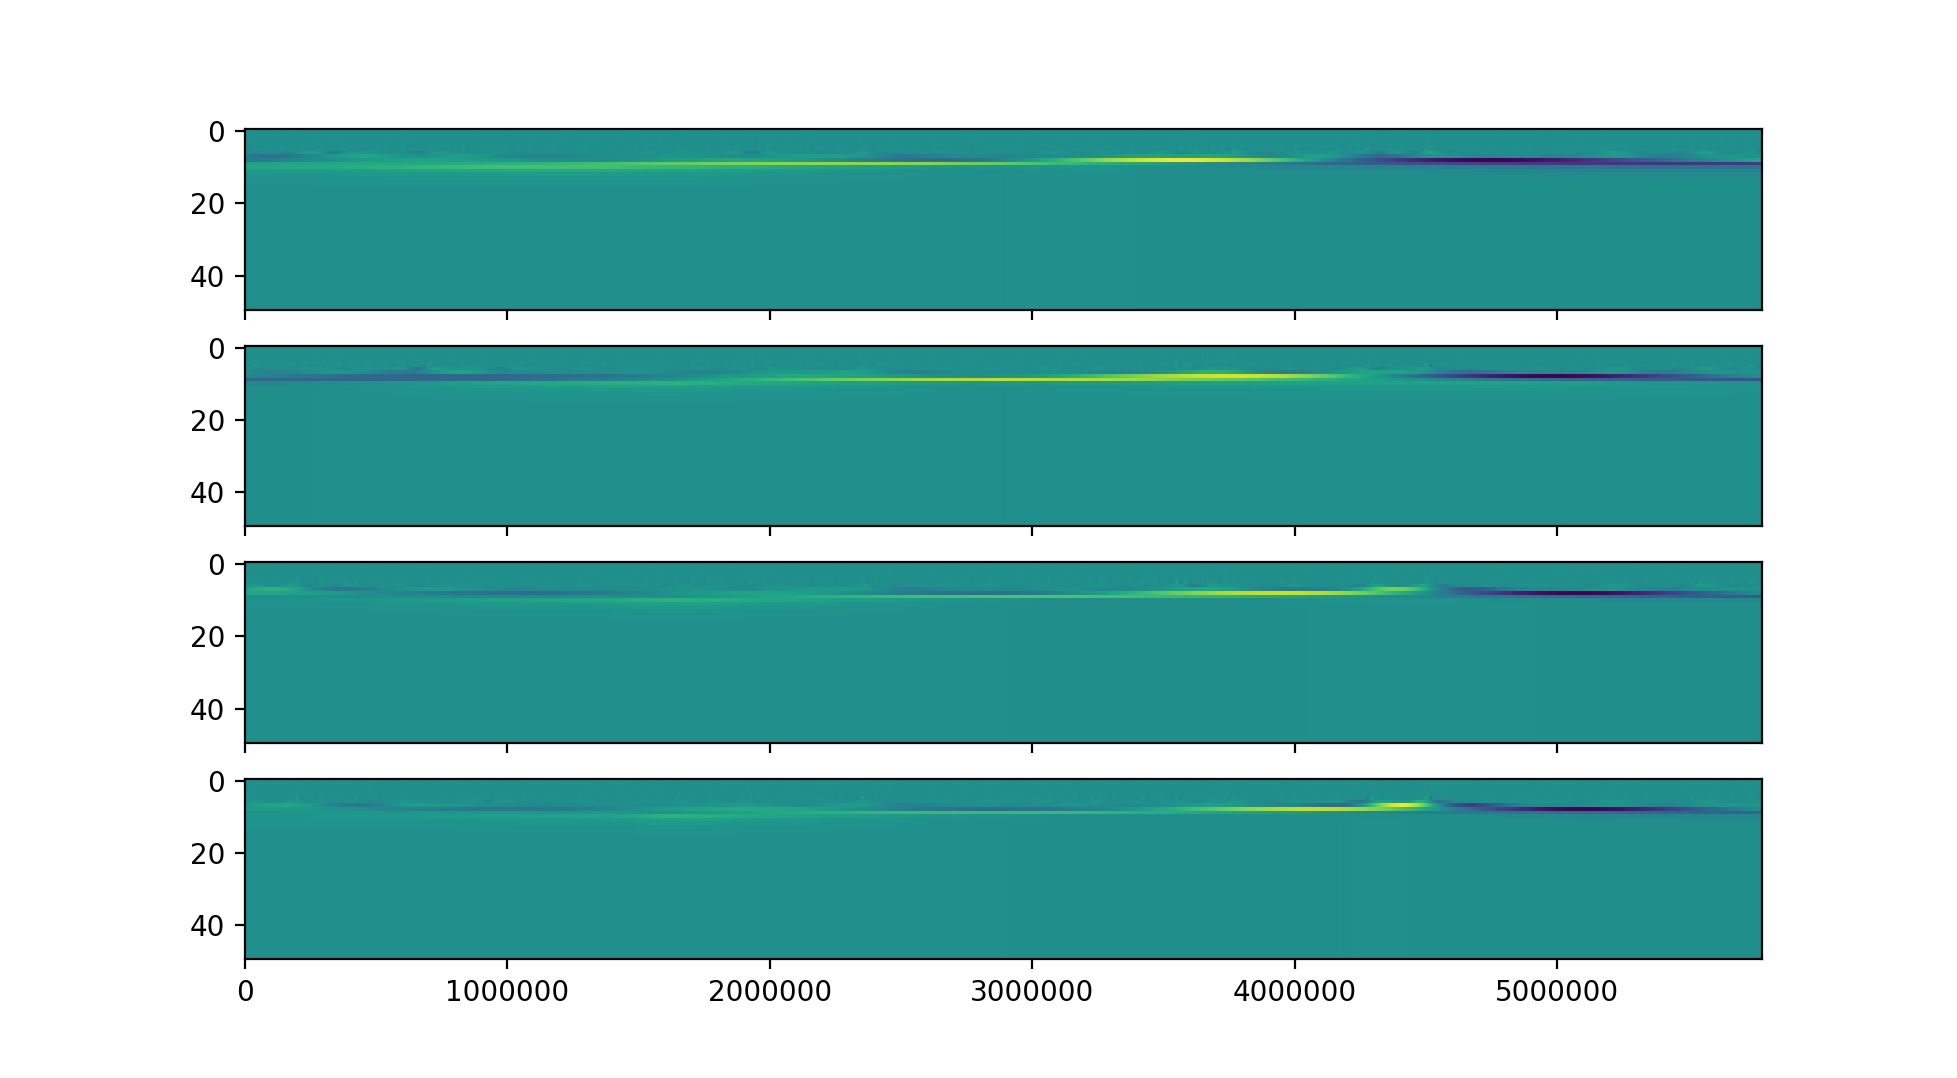

In [30]:
# plot wavelet spectrogram

fig2,ax2 = plt.subplots(4,1,sharex=True)
ax2[0].imshow(cwt0, aspect='auto', vmax=abs(cwt0).max(), vmin=-abs(cwt0).max())
ax2[1].imshow(cwt1, aspect='auto', vmax=abs(cwt1).max(), vmin=-abs(cwt1).max())
ax2[2].imshow(cwt2, aspect='auto', vmax=abs(cwt2).max(), vmin=-abs(cwt2).max())
ax2[3].imshow(cwt3, aspect='auto', vmax=abs(cwt3).max(), vmin=-abs(cwt3).max())

## Dimensionality reduction
Since 4 sensor signals are very similar, use ICA/PCA to decompose signals.

In [ ]:
# ICA

from sklearn.decomposition import FastICA

ica = FastICA()
S_ = ica.fit_transform(data[['c0', 'c1', 'c2', 'c3']]) # reconstruct signals

In [32]:
# PCA

from sklearn.decomposition import PCA

pca = PCA()
H = pca.fit_transform(data[['c0', 'c1', 'c2', 'c3']]) # reconstruct signals

<IPython.core.display.Javascript object>


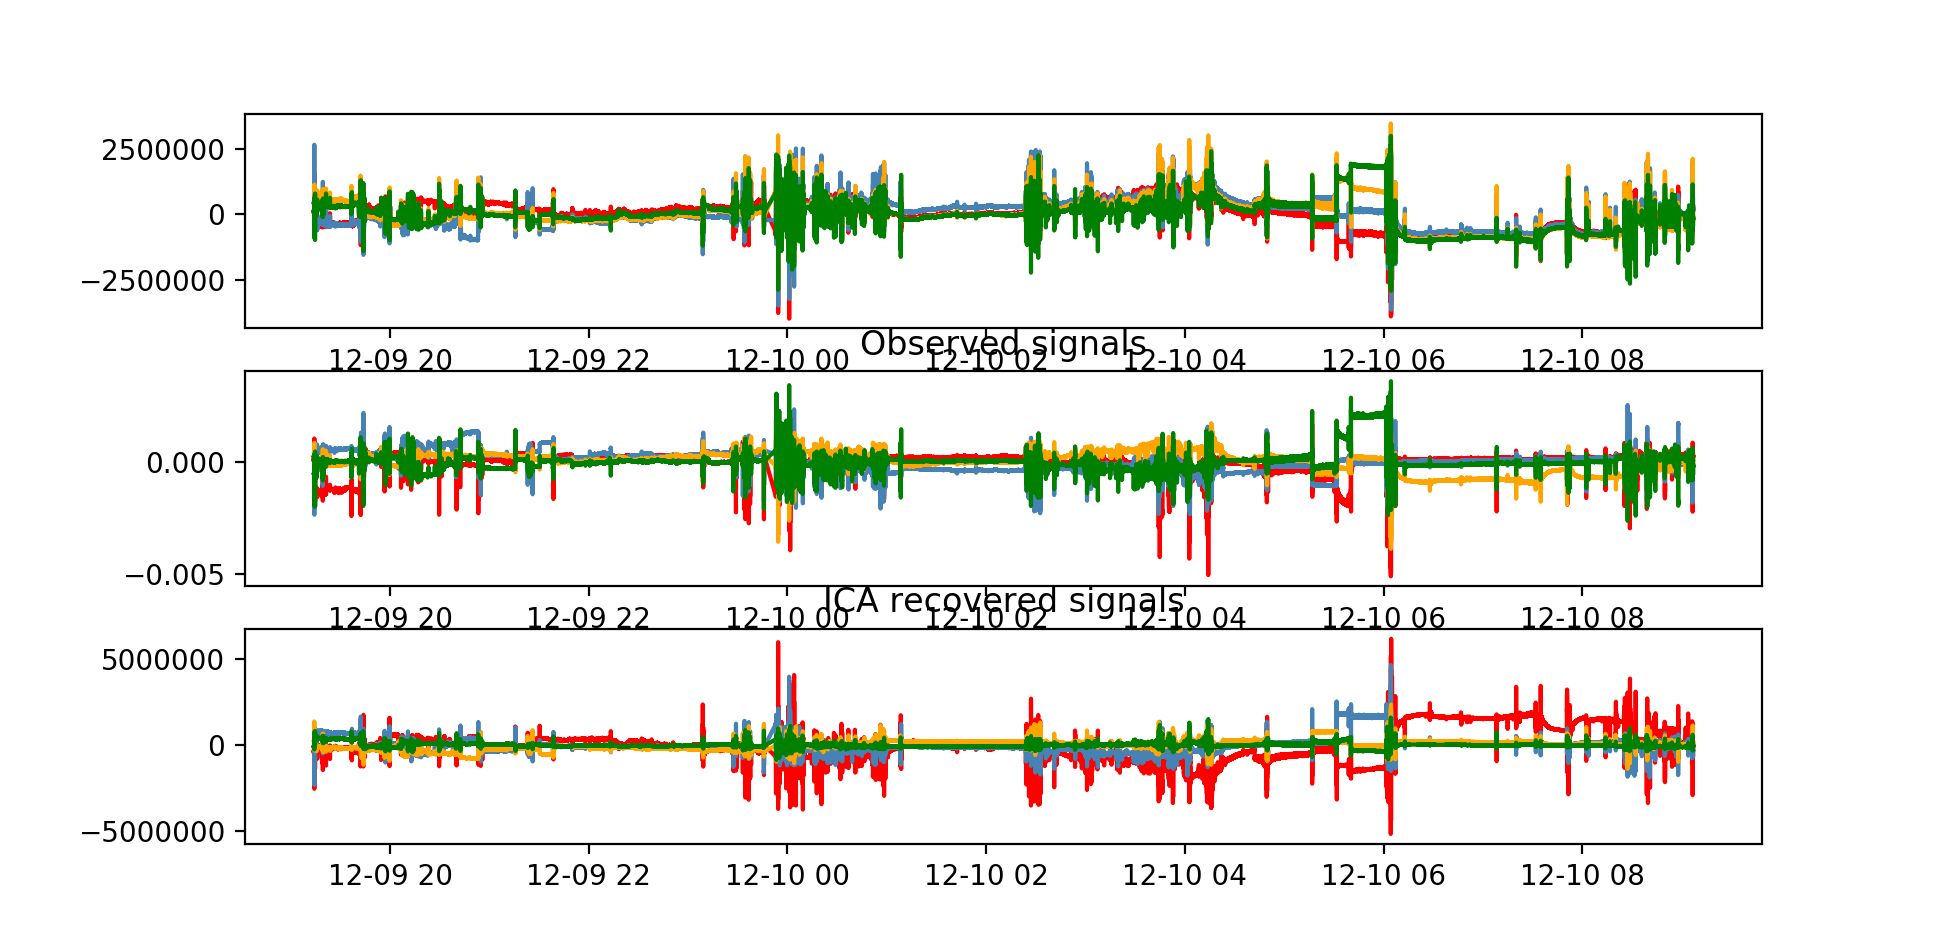

In [34]:
# plot actual signals, ICA recovered signals, PCA recovered signals

plt.figure()

models = [ S_, H]
names = ['Observed signals',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange', 'green']

ax4 = plt.subplot(3,1,1)
plt.plot(data['#time'], data['c0'], color='red')
plt.plot(data['#time'], data['c1'], color='steelblue')
plt.plot(data['#time'], data['c2'], color='orange')
plt.plot(data['#time'], data['c3'], color='green')

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii+1, sharex=ax4)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(data['#time'], sig, color=color)

plt.show()